# Open Data: Renewable Energy in Landkreis Diepholz

In this notebook I want to explore some data I found on https://daten.diepholz.de regarding renewable energy. The dataset contains information regarding installed wind turbines in the region.



## Prepare Notebook

In [4]:
import requests
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'png'

## Wind power

### Read data

In [5]:
url = "http://daten.diepholz.de/api/action/datastore/search.json?resource_id=e8a5d9428bc3e8102cfd7cc11f0666be&limit=-1"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    
    wind_raw_df = pd.json_normalize(data, record_path=['result', 'records'])
else:
    print(F"Error: {response.status_code}")

In [6]:
wind_raw_df.head()

,fid,PARK,STATUS,GEMEINDE,GEMARKUNG,TYP,LEISTUNG_E,ROTOR_D,NABE_H,LAT,LON,UTM,RS_GEMEINDE,KOMMUNE,RS_KOMMUNE,AGS,LANDKREIS
0,3,keine Angabe,Genehmigt,Flecken Barnstorf,Aldorf,ENERCON E-82-E2,2.3,82,108,52.730949,8.519019,32U 467521.0387 5842450.0011,032515402005,Samtgemeinde Barnstorf,032551540200,03251005,Landkreis Diepholz
1,4,keine Angabe,Genehmigt,Flecken Barnstorf,Aldorf,ENERCON E-82-E2,2.3,82,108,52.729893,8.52248,32U 467753.9443 5842331.0447,032515402005,Samtgemeinde Barnstorf,032551540200,03251005,Landkreis Diepholz
2,5,keine Angabe,Genehmigt,Flecken Barnstorf,Aldorf,ENERCON E-82-E2,2.3,82,108,52.729009,8.526072,32U 467995.8466 5842231.0807,032515402005,Samtgemeinde Barnstorf,032551540200,03251005,Landkreis Diepholz
3,12,keine Angabe,Genehmigt,Gemeinde Brockum,Brockum,ENERCON E-53,0.8,52.9,73,52.477089,8.408135,32U 459801.6995 5814268.3176,032515401009,Samtgemeinde Altes Amt Lemförde,032515401000,03251009,Landkreis Diepholz
4,25,keine Angabe,Genehmigt,Gemeinde Dickel,Dickel,ENERCON E-101,3,101,135,52.65427,8.466971,32U 463943.3352 5833945.4315,032515405011,Samtgemeinde Rehden,032515405000,03251011,Landkreis Diepholz


### Format data

In [7]:
columns_to_drop = [
    'STATUS',
    'UTM',
    'RS_GEMEINDE',
    'RS_KOMMUNE',
    'AGS',
    'LANDKREIS'
]

rename_columns = {
    'fid': 'id',
    'PARK': 'park',
    'GEMEINDE': 'municipality',
    'GEMARKUNG': 'district',
    'TYP': 'type',
    'LEISTUNG_E': 'power',
    'ROTOR_D': 'rotor_diameter',
    'NABE_H': 'hub_height',
    'LAT': 'latitude',
    'LON': 'longitude',
    'KOMMUNE': 'community'

}

                 
wind_df = wind_raw_df \
    .copy() \
    .drop(columns = columns_to_drop) \
    .rename(columns = rename_columns)
    
wind_df['power'] = wind_df['power'].astype(float)
wind_df['rotor_diameter'] = wind_df['rotor_diameter'].astype(float)
wind_df['hub_height'] = wind_df['hub_height'].astype(float)

wind_df.head()

,id,park,municipality,district,type,power,rotor_diameter,hub_height,latitude,longitude,community
0,3,keine Angabe,Flecken Barnstorf,Aldorf,ENERCON E-82-E2,2.3,82.0,108.0,52.730949,8.519019,Samtgemeinde Barnstorf
1,4,keine Angabe,Flecken Barnstorf,Aldorf,ENERCON E-82-E2,2.3,82.0,108.0,52.729893,8.52248,Samtgemeinde Barnstorf
2,5,keine Angabe,Flecken Barnstorf,Aldorf,ENERCON E-82-E2,2.3,82.0,108.0,52.729009,8.526072,Samtgemeinde Barnstorf
3,12,keine Angabe,Gemeinde Brockum,Brockum,ENERCON E-53,0.8,52.9,73.0,52.477089,8.408135,Samtgemeinde Altes Amt Lemförde
4,25,keine Angabe,Gemeinde Dickel,Dickel,ENERCON E-101,3.0,101.0,135.0,52.65427,8.466971,Samtgemeinde Rehden


### Exploratory data analysis

In [8]:
print(F"Number of turbines: {len(wind_df)}")
print(F"Total amount of installed power: {wind_df['power'].sum()} MW")

Number of turbines: 402
Total amount of installed power: 739.815 MW


#### Installed power by community

In [9]:
wind_df \
    .groupby(['community']) \
    .agg(installed_power = ('power', 'sum')) \
    .sort_values('installed_power', ascending=False) 

,installed_power
community,
Samtgemeinde Schwaförden,140.400
Samtgemeinde Barnstorf,83.800
Stadt Bassum,82.860
Stadt Twistringen,74.950
Samtgemeinde Siedenburg,57.580
Samtgemeinde Kirchdorf,54.310
Stadt Sulingen,50.700
Samtgemeinde Bruchhausen-Vilsen,50.250
Samtgemeinde Rehden,45.255


#### Number of installed turbines by community

In [10]:
wind_df \
    .groupby(['community']) \
    .agg(num_turbines = ('id', 'count')) \
    .sort_values('num_turbines', ascending=False)

,num_turbines
community,
Samtgemeinde Schwaförden,75
Stadt Bassum,44
Samtgemeinde Barnstorf,37
Samtgemeinde Bruchhausen-Vilsen,32
Stadt Twistringen,31
Samtgemeinde Siedenburg,30
Samtgemeinde Kirchdorf,29
Stadt Sulingen,28
Samtgemeinde Rehden,21


## Graphs

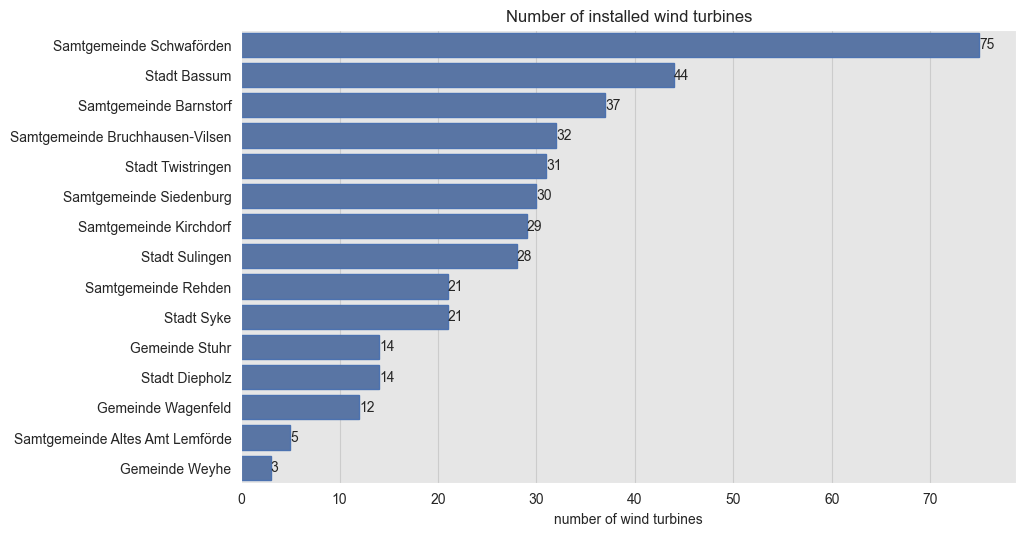

In [11]:
fig, ax = plt.subplots()

wind_df \
    .groupby(['community']) \
    .agg(num_turbines = ('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('num_turbines', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='num_turbines', 
        y='community',
        color=sns_c[0],
        edgecolor=sns_c[0],
        ax=ax
    )

ax.set(
    title='Number of installed wind turbines', 
    xlabel='number of wind turbines', 
    ylabel=''
)

ax.bar_label(ax.containers[0]);

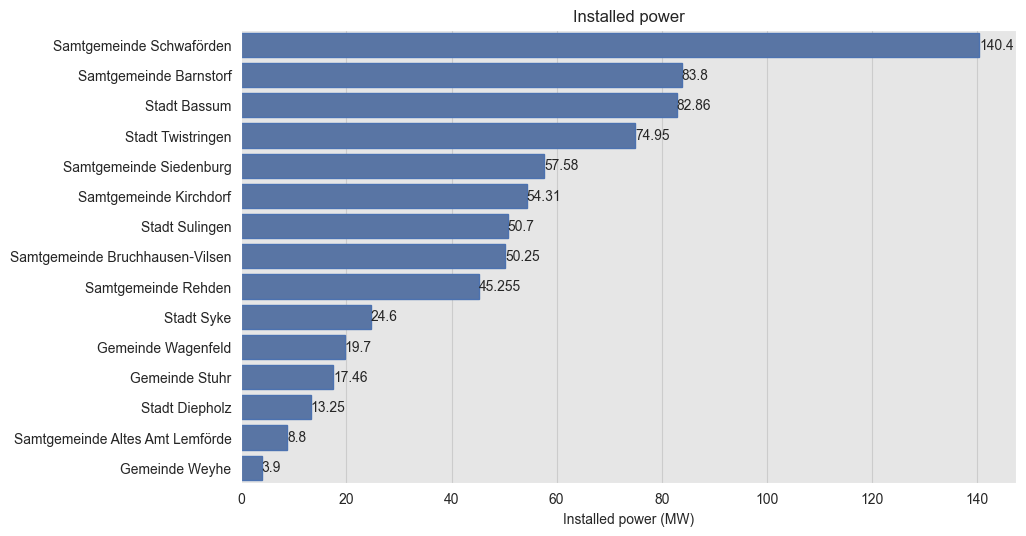

In [12]:
fig, ax = plt.subplots()

wind_df \
    .groupby(['community']) \
    .agg(num_turbines = ('power', 'sum')) \
    .reset_index(drop=False) \
    .sort_values('num_turbines', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='num_turbines', 
        y='community',
        color=sns_c[0],
        edgecolor=sns_c[0],
        ax=ax
    )

ax.set(
    title='Installed power', 
    xlabel='Installed power (MW)', 
    ylabel=''
)

ax.bar_label(ax.containers[0]);

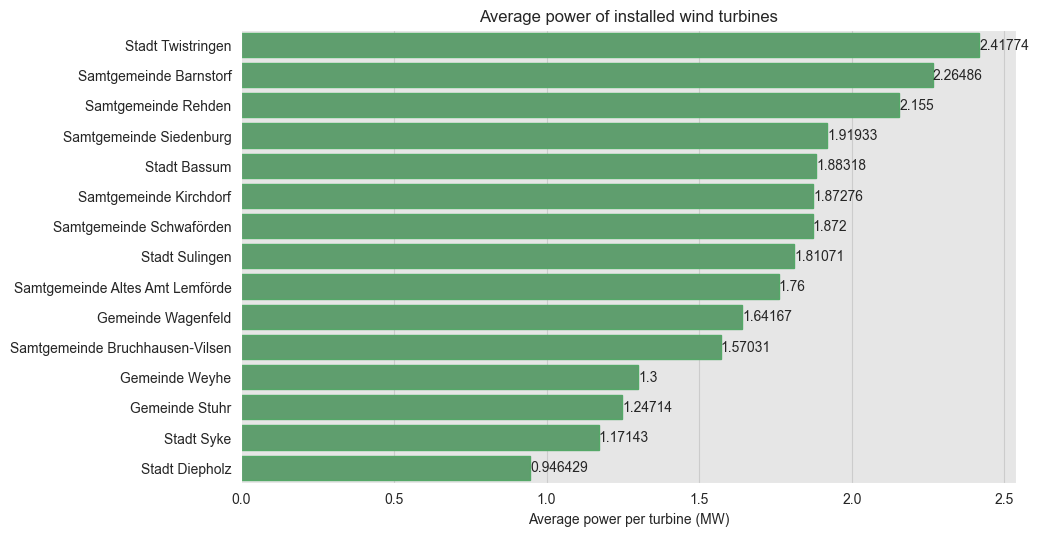

In [13]:
fig, ax = plt.subplots()

wind_df[['community', 'power']] \
    .groupby(['community']) \
    .agg(['sum', 'count']) \
    .reset_index(drop=False) \
    .assign(power_per_turbine = lambda x: x['power']['sum'] / x['power']['count']) \
    .sort_values('power_per_turbine', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='power_per_turbine', 
        y='community',
        color=sns_c[2],
        edgecolor=sns_c[2],
        ax=ax
    )

ax.set(
    title='Average power of installed wind turbines', 
    xlabel='Average power per turbine (MW)', 
    ylabel=''
)

ax.bar_label(ax.containers[0]);

## Technical propertis of the wind turbines

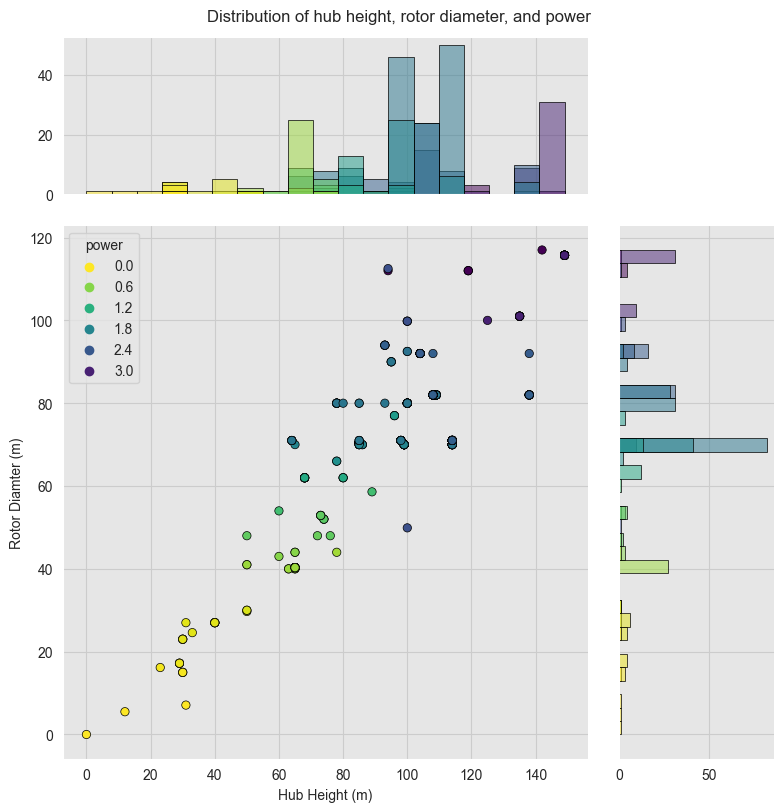

In [14]:
g = wind_df \
        .pipe((sns.JointGrid, 'data'), 
        y='rotor_diameter',  
        x='hub_height',
        height=8,
        ratio=3,
        hue='power',
        palette='viridis_r',
        marginal_ticks=True
    )

g.plot(sns.scatterplot, sns.histplot, edgecolor='black', linewidth=0.5)

g.set_axis_labels(ylabel='Rotor Diamter (m)', xlabel='Hub Height (m)')
g.fig.suptitle('Distribution of hub height, rotor diameter, and power', y=1.01);

As expected: larger rotor diameters lead to more power.

### Distribution of wind turbine models

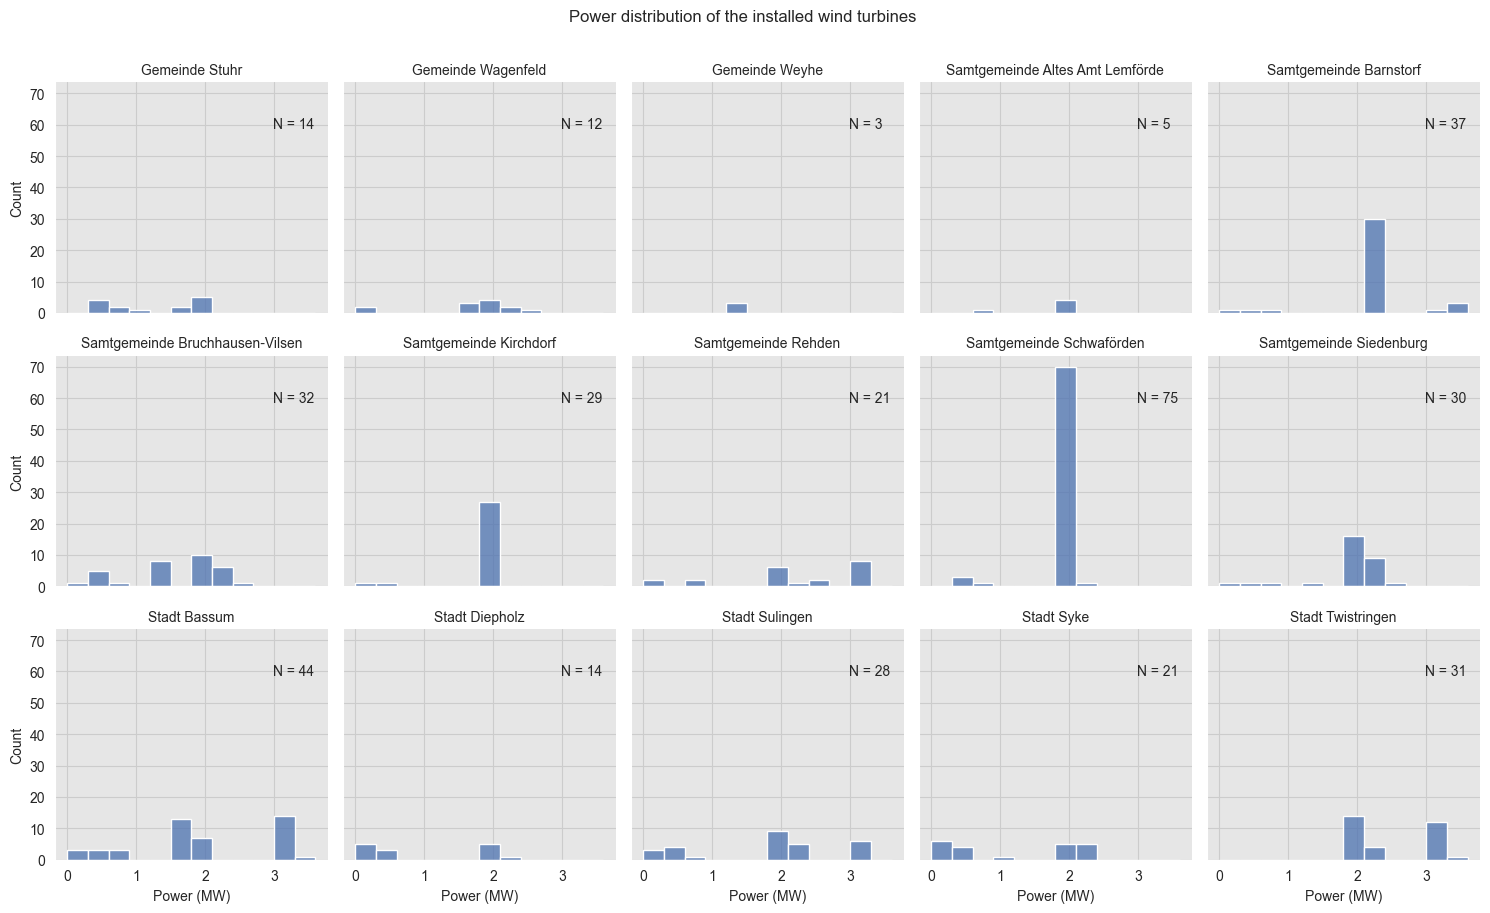

In [16]:
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.8, .8, f"N = {n}", transform=ax.transAxes)


g = wind_df \
    .sort_values('community', ascending=True) \
    .pipe((sns.FacetGrid, 'data'),
        col='community', 
        col_wrap=5, 
        height=3,
    )

g.map_dataframe(sns.histplot, x="power", binwidth=0.3, binrange=(0, 3.6))

g.fig.suptitle('Power distribution of the installed wind turbines ', y=1.01)
g.map_dataframe(annotate)
g.set_axis_labels("Power (MW)", "Count")
g.set_titles(col_template="{col_name}");

Conclusions from this plot:

In the joint municipalities of Kirchdorf, Schwaförden and Barnstorf, wind turbines of a certain size are mainly installed. This may indicate that there are mainly wind farms here, in contrast to the other municipalities, where the turbines were installed at different times or by different operators. 

Therefore, lets look in more detail into Kirchdorf, Barnstof and Schwaförden.

In [47]:
# Samtgemeine Kirchdorf

wind_df \
    .query("community == 'Samtgemeinde Barnstorf'") \
    .groupby(['district', 'type']) \
    .agg(n=('type', 'count')) \
    .sort_values('n', ascending=False)

,,n
district,type,
Düste,ENERCON E-92,7
Drentwede,ENERCON E-92,4
Barnstorf,ENERCON E-92,4
Wohlstreck,ENERCON E-82-E2,3
Donstorf,ENERCON E-82-E2,3
Aldorf,ENERCON E-82-E2,3
Drentwede,VESTAS V 112,2
Wohlstreck,ENERCON E-82 E2,1
Mariendrebber,ENERCON E-53,1


In [48]:
wind_df \
    .query("community == 'Samtgemeinde Kirchdorf'") \
    .groupby(['district', 'type']) \
    .agg(n=('type', 'count')) \
    .sort_values('n', ascending=False)

n
district        type                  
Holzhausen      ENERCON E-70 E4     15
Barenburg       ENERCON E-82         3
Wehrbleck       VESTAS V 80/2 MW     3
Kuppendorf      VESTAS V 80/2 MW     2
Barenburg       ENERCON E-40/5       1
                VESTAS V 80/2 MW     1
Dörrieloh       AIRCON A10           1
Kuppendorf      VESTAS V 90/2 MW     1
Scharringhausen ENERCON E-66/18.70   1
Schweringhausen ENERCON E-70 E4      1

In [49]:
wind_df \
    .query("community == 'Samtgemeinde Schwaförden'") \
    .groupby(['district', 'type']) \
    .agg(n=('type', 'count')) \
    .sort_values('n', ascending=False)

,,n
district,type,
Schwaförden,ENERCON E-70 E4,20
Scholen,ENERCON E-66/18.70,9
Stocksdorf,ENERCON E-66/18.70,6
Schmalförden,ENERCON E-66/18.70,4
Wesenstedt,ENERCON E-70 E4,4
Mallinghausen,ENERCON E-70 E4,3
Scholen,ENERCON E-70 E4,3
Schmalförden,ENERCON E-82,3
Schweringhausen,VESTAS V 90/2 MW,3


In [18]:
# g = wind_df \
#     .groupby(['community', 'type'], as_index=False) \
#     .agg(n=('type', 'count')) \
#     .sort_values('community', ascending=True) \
#     .pipe((sns.FacetGrid, 'data'),
#         col='community', 
#         col_wrap=5, 
#         height=4,
#     )

# g.map_dataframe(sns.barplot, x="n", y='type')
# g.map_dataframe(annotate)
# g.set_titles(col_template="{col_name}");